# Iterative Use of Cleanlab to Improve Classification Models (and Consensus Labels) from Data Labeled by Multiple Annotators

This example shows how to improve consensus labels established from data labeled by multiple annotators by combining the CROWDLAB algorithm with iteratively retraining a model. For an introductory tutorial on finding consensus labels with the multiannotator library see [Find Best Consensus Labels for Multiannotator Data using Cleanlab](linke to hui wen's). 

As our multiannotator dataset, we use a subset of [CIFAR-10h](https://github.com/jcpeterson/cifar-10h) (Peterson et al., 2019) multiannotator labeling dataset which is a collection of 2751 annotators each labeling 200 examples for all 10,000 test images of the original [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

Because this notebook utilizes AutoML for model training and Cleanlab is compatible with any model/dataset, you should be able to run the below code with any image classification dataset where each image has been labeled by multiple annotators.

## 1. Install and import required dependencies, build example folder

In [18]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime

from utils.model_training import train_model, sum_xval_folds
from cleanlab.multiannotator import get_majority_vote_label, get_label_quality_multiannotator

In [14]:
experiment_path = "./experiment"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
    print("Directory " , experiment_path ,  " Created ")
else:    
    print("Directory " , experiment_path ,  " already exists")

print(f'Experiment saved in {experiment_path}')

Directory  ./experiment  already exists
Experiment saved in ./experiment


In [3]:
# Download CIFAR-10 data for model training
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10/cifar10_test.tar.gz'
!tar -xzf cifar10_test.tar.gz

# Here is an alternative command to download the data from the source:
# cifar2png cifar10 ./data/cifar10_test --name-with-batch-index

# Import CIFAR-10h labels and image paths
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_labels_worst25_coin20.npy'
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_image_paths.npy'
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_test_labels.npy'

File ‘cifar10_test.tar.gz’ already there; not retrieving.

File ‘c10h_labels_worst25_coin20.npy’ already there; not retrieving.

File ‘c10h_image_paths.npy’ already there; not retrieving.

File ‘c10h_test_labels.npy’ already there; not retrieving.



## 2. Load multiannotator labels and generate consensus labels for them
`multiannotator_labels` for this example is a precalculated subset of the original `CIFAR-10h` annotator labels.

In [4]:
# Load labels
multiannotator_labels = np.load(f'{experiment_path}/c10h_labels_worst25_coin20.npy')

# Load and reformat image paths to work for specific machine
image_paths = np.load(f'{experiment_path}/c10h_image_paths.npy', allow_pickle=True)
path = os.getcwd()
image_paths = [f"{path}/{image_path}" for image_path in image_paths]

<div class="alert alert-info">
Bringing Your Own Data (BYOD)?

You can easily replace the above with your own multiannotator dataset, and continue with the rest of the example.

`multiannotator_labels` should be a numpy array or pandas DataFrame with each column representing an annotator and each row representing an example. Your classes (and entries of `multiannotator_labels`) should be represented as integer indices 0, 1, ..., num_classes - 1, where examples that are not annotated by a particular annotator are represented using `np.nan`.
    
If working with images, `image_paths` should be a string of absolute or relative paths to the where each index corresponds the example for that row of `multiannotator_labels`.

If working with other data, `image_paths` should be a string of examples corresponding to the row of `multiannotator_labels`.

</div>


Before training our machine learning model, we must first obtain the consensus labels from the annotators that labeled the data. The simplest way to obtain an initial set of consensus labels is to select it using majority vote.

In [5]:
consensus_labels = get_majority_vote_label(multiannotator_labels)

## 3. Train model and use cleanlab to get better consensus labels

Next, we will train our model on the consensus labels obtained using majority vote to compute out-of-sample predicted probabilities. We will then use these `pred_probs` to generate more informed `consensus_labels` using Cleanlab's [CROWDLAB](link to something) algorithm. We then use these `consensus_labels` to train a better model that generates more accurate `pred_probs`. This process iterates until the `consensus_labels` have no more improvement.

`train_model()` trains a `resnet18` image model using cross validation to get out-of-sample predicted probabilities on the whole dataset. The function can be replaced with a custom training algorithm.

We use the [AutoGluon](https://auto.gluon.ai/) library to train powerful image classifiers (Residual Network or Swin Transformer), but this requires a GPU to run in a reasonable time.

In [6]:
model_type = "resnet18" # You can also try with "swin_base_patch4_window7_224"

# Load model arguments
train_args = {
    "num_cv_folds": 5, # decrease this value if you want code to run faster
    "verbose": 1, 
    "epochs": 50, # decrease this value if you want code to run faster
    "time_limit": 7200, # decrease this value if you want code to run faster
    "random_state": 123,
}

In [ ]:
%%capture

#Loop through and retrain model on better consensus labels, save results
indices_changed = set()
seen_consensus_labels = list()
model_results = {}
rounds = 0
MAX_ROUNDS = 3

while tuple(consensus_labels) not in seen_consensus_labels and rounds < MAX_ROUNDS:
    seen_consensus_labels.append(tuple(consensus_labels)) # add curent consensus labels into the set
    model_results['rounds'] = rounds
    model_xval_results_folder = f'{experiment_path}/xval_results_round{rounds}' # + [model_type]

    # Zip consensus labels with their corresponding image_paths
    consensus_data = pd.DataFrame(zip(image_paths,consensus_labels), columns=["image", "label"])
    
    # Train model
    train_model(model_type, consensus_data, model_xval_results_folder, **train_args);
    pred_probs, labels, images = sum_xval_folds(model_type, model_xval_results_folder, **train_args)
    
    # Get improved consensus labels with label quality multiannotator using model pred probs
    label_quality_multiannotator = get_label_quality_multiannotator(multiannotator_labels, pred_probs, verbose=False)
    consensus_labels = label_quality_multiannotator["label_quality"]["consensus_label"].tolist()
    
    unique_indices = len(indices_changed)
    indices_changed.update(list(np.where(consensus_labels != np.array(seen_consensus_labels[-1]))[0]))
    unique_indices = len(indices_changed) - unique_indices
    label_changes_from_prior = np.sum(consensus_labels != np.array(seen_consensus_labels[-1]))
    
    print("Num changes in consensus labels from previous round: ", np.sum(consensus_labels != np.array(seen_consensus_labels[-1])))
    print("Num unique indices changed: ", unique_indices)
    # End to delete
    
    results = {
        "pred_probs": pred_probs,
        "consensus_labels_in": labels, # consensus labels used to train the model
        "images": images, 
        "consensus_labels_out": consensus_labels, # new consensus labels generated from pred_probs
        "label_changes_from_prior": label_changes_from_prior, # num changes in consensus labels from previous iterations
        "unique_indices_added": unique_indices, # number of unique labels indices changed
    }
    
    model_results[rounds] = results
    rounds+=1
    
    if unique_indices == 0: # no more label improvement
        break

## 4. Evaluate consensus labels and model predictions
Since our annotators annotated a dataset `CIFAR-10` to which there exist [highly accurate](https://arxiv.org/abs/2103.14749) `true_labels`, we can evaluate the accuracy of our methods against ground truth gold labels.

In a true multiannotator setting this would not be possible since ground truth labels will not exist. Instead we have [benchmarked](link paper or blogpost maybe) this method to ensure this method produces more accurate `consensus_labels` than popular existing methods for establishing a consensus label from data labeled by multiple annotators.

In [8]:
# Load ground truth labels (once again this is only for metrics, normally not have this information)
true_labels = np.load(f'{experiment_path}/c10h_test_labels.npy')

In [9]:
# Calculate CROWDLAB performance against the ground truth for each round
for i in range(rounds):
    pred_probs = model_results[i]['pred_probs']
    consensus_labels_in = model_results[i]['consensus_labels_in']
    consensus_labels_out = model_results[i]['consensus_labels_out']

    acc_model_gtruth = (pred_probs.argmax(axis=1) == true_labels).mean()
    acc_consensus_gtruth = (consensus_labels_in == true_labels).mean()

    results = {
        "consensus_gtruth_accuracy": acc_consensus_gtruth, # consensus labels accuracy 
        "model_gtruth_accuracy": acc_model_gtruth,         # model label accuracy
    }
    
    model_results[i].update(results)

# Calculate accuracy of final CROWDLAB generated consensus label
final_consensus_labels = model_results[rounds-1]["consensus_labels_out"]
final_consensus_accuracy = (final_consensus_labels == true_labels).mean()

print("Final consensus label accuracy (vs ground truth): ", final_consensus_accuracy)
print("Final model predictions accuracy (vs ground truth): ", model_results[rounds-1]["model_gtruth_accuracy"])

Final consensus label accuracy (vs ground truth):  0.9688
Final model predictions accuracy (vs ground truth):  0.9063


Finally lets plot the accuracy of the `consensus_labels` and the model over multiple rounds. 

Here round 0 corresponds to the initial `consensus_labels` generated using majority vote without the help of a model and initial model training results. Generating consensus with majority vote is the most common practice and therefore makes a great baseline to compare CROWDLAB against.

As you can see, the accuracy of the `consensus_labels` improves over several rounds.

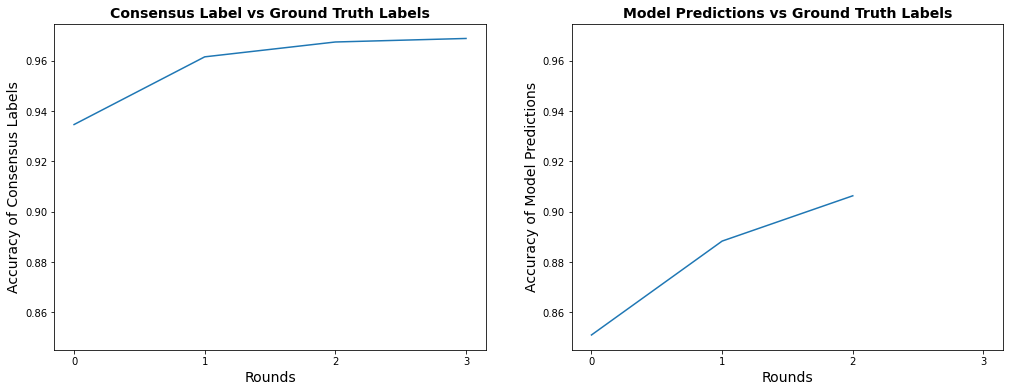

In [19]:
consensus_gtruth_accuracy = [model_results[i]["consensus_gtruth_accuracy"] 
                             for i in range(rounds)] + [final_consensus_accuracy]

model_gtruth_accuracy = [model_results[i]["model_gtruth_accuracy"] for i in range(rounds)]


# plot prc
plt.rcParams["figure.figsize"] = (17,6)
plt.show()

ax1 = plt.subplot(1, 2, 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(range(0, rounds+1),consensus_gtruth_accuracy)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("Accuracy of Consensus Labels", fontsize=14)
plt.title("Consensus Label vs Ground Truth Labels", fontsize=14, fontweight="bold")

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.plot(range(0, rounds), model_gtruth_accuracy)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("Accuracy of Model Predictions", fontsize=14)
plt.title("Model Predictions vs Ground Truth Labels", fontsize=14, fontweight="bold")

plt.show()

In [11]:
# Only to be executed during CI
# if consensus_gtruth_accuracy[0] >= consensus_gtruth_accuracy[-1]:  # check cleanlab has improved prediction accuracy
#     raise Exception("Cleanlab failed to improve baseline consensus label accuracy.")

#### CIFAR-10h dataset attribution
Peterson, J.*, Battleday, R.*, Griffiths, T., & Russakovsky, O. (2019).
    Human uncertainty makes classification more robust.
    In Proceedings of the IEEE International Conference on Computer Vision.